In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'  # default is ‘last_expr’

%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/Users/siyuyang/Source/Repos/GitHub_MSFT/CameraTraps')

In [111]:
import json
import os
from collections import defaultdict, Counter
from random import sample

import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from azure.storage.blob import BlobServiceClient
from PIL import Image

# requires the TF Object Detection API be installed
from detection.detector_eval import detector_eval  # detector_eval.py functions in this directory
from visualization import visualization_utils as viz_utils

# MegaDetector v4 experiments - evaluation

For MDv2 results, some locations in its training set are in this test set (MDv4 test set).

In [27]:
mdv4boxes_label_path = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/Databases/query_results/bboxes_inc_empty_20200325.json'

res_dir = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/MegaDetectorEval/megadetectorv4/mdv4_1_results'
test_set_res_paths = {
    'MDv4.1 cos LR aug epoch 5.8': '2891_detections_mdv4_1_run10_step3016k_on_test_20200427004012.json',
    'MDv4.1 cos LR aug epoch 3.8': '7230_detections_mdv4_1_run10_step1976k_on_test_20200427003838.json',
    'MDv4.1 cos LR epoch 5.6': '1831_detections_mdv4_1_run9_step2912k_on_test_20200427003715.json',
    'MDv4.1 epoch 7.6': '6725_detections_mdv4_1_run5_step3952k_on_test_20200427003551.json',
    'MDv4.1 epoch 5.8': '1654_detections_mdv4_1_run5_step3016k_on_test_20200427003431.json',
    'MDv4 aug': '6706_detections_mdv4_aug_run4_step1160k_on_test_20200427005009.json',
    'MDv4 baseline': '3014_detections_mdv4_on_test_20200427004828.json'
}

out_dir = '/Users/siyuyang/OneDrive - Microsoft/AI4Earth/CameraTrap/MegaDetectorEval/megadetectorv4/mdv4_1_results/plots'

## Matching label and predicted boxes

In [ ]:
test_set_res = {}
for checkpoint_name, out_name in test_set_res_paths.items():
    with open(os.path.join(res_dir, out_name)) as f:
        test_set_res[checkpoint_name] = json.load(f)['images']
    print('{}, number of results: {}'.format(checkpoint_name, len(test_set_res[checkpoint_name])))

In [6]:
# for numerical IDs from output files of the API, and names in the MegaDB
label_map_name_to_id = {
    'animal': 1,
    'person': 2,
    'vehicle': 3
}

In [7]:
test_set_res['MDv4 baseline'][100]

{'file': 'mdv4_images/test/wcs+8a02345a-3f14-11ea-92bb-9801a7a664ab.jpg',
 'max_detection_conf': 1.0,
 'detections': [{'category': '1',
   'conf': 1.0,
   'bbox': [0.3468, 0.4422, 0.2385, 0.2146]},
  {'category': '1', 'conf': 0.987, 'bbox': [0.9007, 0.3621, 0.0985, 0.1064]}]}

In [8]:
test_set = set([i['file'].split('/')[-1].split('.jpg')[0] for i in test_set_res['MDv4 baseline']])
len(test_set)

20468

In [9]:
with open(mdv4boxes_label_path) as f:
    mdv4boxes_labels = json.load(f)

In [10]:
len(mdv4boxes_labels)
mdv4boxes_labels[100]

570092

{'bbox': [{'category': 'animal', 'bbox': [0.2, 0.722, 0.232, 0.221]},
  {'category': 'animal', 'bbox': [0.221, 0.637, 0.0895, 0.122]}],
 'file': 'Beaverhead_elk/AM58/Trip 1/100RECNX/2016-02-03 12-48-58 M 2_5.JPG',
 'dataset': 'idfg',
 'location': 'Beaverhead_elk+AM58',
 'download_id': 'idfg+4e999ed1-659e-4f74-b396-3998463b8ae6',
 'new_entry': True}

In [11]:
mdv4boxes_labels_dict = {}
for i in mdv4boxes_labels:
    if i['download_id'] in test_set:
        mdv4boxes_labels_dict[i['download_id']] = i
print(len(mdv4boxes_labels_dict))

20468


In [12]:
mdv4boxes_labels_dict['zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab']

{'bbox': [{'category': 'animal', 'bbox': [0.02823, 0.2205, 0.02278, 0.08518]}],
 'file': 'Maliau/Maliau_3/OG1-E-38/20120416-005602(2)10 of 10.jpg',
 'dataset': 'zsl_borneo',
 'location': 'OG1-E-38',
 'download_id': 'zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab'}

In [134]:
test_set_by_dataset = defaultdict(int)
for i in mdv4boxes_labels:
    if i['download_id'] in test_set:
        test_set_by_dataset[i['dataset']] += 1

In [ ]:
sorted(test_set_by_dataset.items(), key=lambda x: x[0])

## Compute metrics

In [ ]:
checkpoint_metrics = {}

for checkpoint_name, detection_res in test_set_res.items():
    print(checkpoint_name)
    
    per_image_gts, per_image_detections = detector_eval.get_per_image_gts_and_detections(
        mdv4boxes_labels_dict, detection_res, label_map_name_to_id)
        
    print('Lengths of per_image_gts is {}, per_image_detections is {}'.format(
        len(per_image_gts), len(per_image_detections)))
    
    per_cat_metrics = detector_eval.compute_precision_recall_bbox(per_image_detections, per_image_gts, 3, 
                                                    matching_iou_threshold=0.5)

    checkpoint_metrics[checkpoint_name] = per_cat_metrics
    print('one_class average precision is {}'.format(per_cat_metrics['one_class']['average_precision']))
    print('-----------')
    

## Plot precision-recall

In [14]:
categories = {
    1: 'animal',
    2: 'person',
    3: 'vehicle',
    'one_class': 'one class'
}

In [15]:
for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():            
    print(checkpoint_name)
    average_precision_category = []
    for cat in categories:
        print(cat)
        ave_prec = per_cat_metrics[cat]['average_precision']
        print(ave_prec)
        if cat in [1, 2, 3] and ave_prec > 0:
            average_precision_category.append(ave_prec)
    
    mAP = sum(average_precision_category) / len(average_precision_category)
    print('mAP is {}'.format(mAP))
    print('-----------')

MDv4.1 cos LR aug epoch 5.8
1
0.8701549161772134
2
0.9306805816326822
3
0.9096424325990644
one_class
0.8788542894327809
mAP is 0.9034926434696534
-----------
MDv4.1 cos LR aug epoch 3.8
1
0.8681920422685518
2
0.932010653519139
3
0.9037144486960861
one_class
0.8769928955170816
mAP is 0.9013057148279257
-----------
MDv4.1 cos LR epoch 5.6
1
0.8780303028152383
2
0.9342826979123573
3
0.8969026947933176
one_class
0.8861010194865517
mAP is 0.9030718985069711
-----------
MDv4.1 epoch 7.6
1
0.8780935893887386
2
0.9339168303685309
3
0.9166736916587306
one_class
0.8863746452552632
mAP is 0.9095613704720001
-----------
MDv4.1 epoch 5.8
1
0.8786706792453995
2
0.9330299798452961
3
0.9203857837466889
one_class
0.8864350253142375
mAP is 0.9106954809457948
-----------
MDv4 aug
1
0.8720859293686467
2
0.9266237345639334
3
0.9036554968836412
one_class
0.8799355238385914
mAP is 0.9007883869387404
-----------
MDv4 baseline
1
0.8693864959891899
2
0.9211235610439354
3
0.8980362991143584
one_class
0.876674288

In [38]:
list(test_set_res_paths.keys())

['MDv4.1 cos LR aug epoch 5.8',
 'MDv4.1 cos LR aug epoch 3.8',
 'MDv4.1 cos LR epoch 5.6',
 'MDv4.1 epoch 7.6',
 'MDv4.1 epoch 5.8',
 'MDv4 aug',
 'MDv4 baseline']

In [44]:
# Cosine decay learning rate vs step learning rate
runs_to_show = [
    'MDv4.1 epoch 5.8',
    'MDv4.1 cos LR epoch 5.6'
]

cat_to_fig = {}
for cat, cat_label in categories.items():
    fig = matplotlib.figure.Figure(figsize=(3, 3), dpi=150)
    ax = fig.add_axes((0, 0, 1, 1))
    
    for checkpoint_name in runs_to_show:
        per_cat_metrics = checkpoint_metrics[checkpoint_name]
        
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=1)  
    
    _ = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), shadow=False, ncol=2)
    _, _ = ax.set_xlim(left=0.0, right=1.0)
    
    _ = ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')
    _ = ax.set_title('category: ' + cat_label)
    
    cat_to_fig[cat] = fig

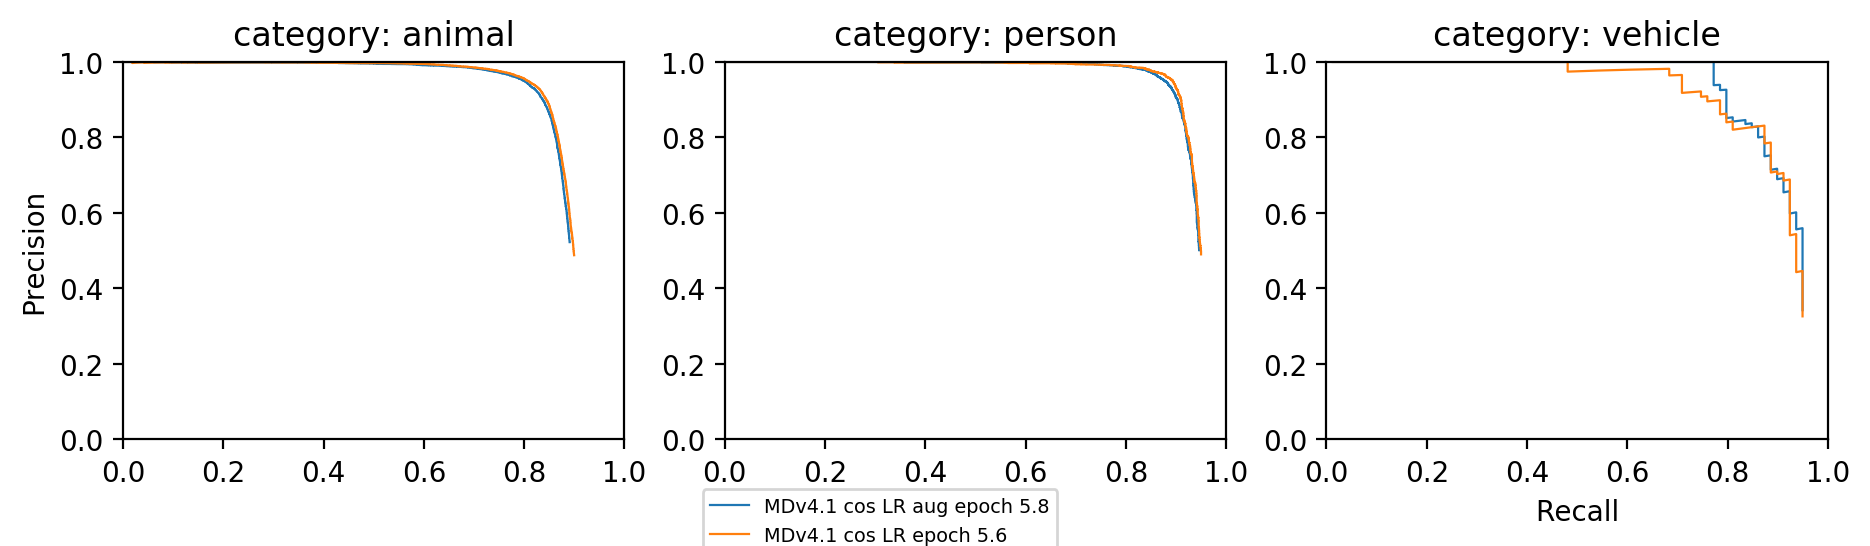

In [70]:
runs_to_show = [
    'MDv4.1 cos LR epoch 5.6',
    'MDv4.1 cos LR aug epoch 5.8'
]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, figsize=(11, 2.5), dpi=200)


for cat, cat_label, ax in zip([1, 2, 3], ['animal', 'person', 'vehicle'], [ax1, ax2, ax3]):
    for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
        if checkpoint_name not in runs_to_show:
            continue
            
        _ = ax.plot(per_cat_metrics[cat]['recall'], per_cat_metrics[cat]['precision'], 
                    label=checkpoint_name,
                    linewidth=0.8)  
        _, _ = ax.set_xlim(left=0.0, right=1.0)
        _, _ = ax.set_ylim(bottom=0.0, top=1.0)
        
        if cat == 3:
            _ = ax.set_xlabel('Recall')
        if cat == 1:
            _ = ax.set_ylabel('Precision')
            
        _ = ax.set_title('category: ' + cat_label)

lines, labels = fig.axes[-1].get_legend_handles_labels()
_ = fig.legend(lines, labels, loc='center', bbox_to_anchor=(0.4, 0.05), fontsize='x-small')

## Number of true and false positives

In [ ]:
for checkpoint_name, per_cat_metrics in checkpoint_metrics.items():
    
    if checkpoint_name not in runs_to_show:
        continue
    
    print('\n{}'.format(checkpoint_name))
    for category, metrics in per_cat_metrics.items():
        print('category: {}'.format(category))
        for score_threshold in [0.5, 0.8, 0.9, 0.97]:
            total_tp = 0
            total_fp = 0
            for score, tp_fp in zip(metrics['scores'], metrics['tp_fp']):
                if score > score_threshold:
                    if tp_fp == 1:
                        total_tp += 1
                    else:
                        total_fp += 1
                        
            ratio = total_tp/total_fp if total_fp > 0 else None
            print('    score_threshold: {}, tp: {}, fp: {}, tp:fp ratio: {}'.format(
                score_threshold, total_tp, total_fp, ratio))

## Visualize some results

In [78]:
label_map = {
    '1': 'animal',
    '2': 'person',
    '3': 'vehicle'  # will be available in megadetector v4
}

In [87]:
test_im_dir = '/Users/siyuyang/Source/temp_data/CameraTrap/samples/mdv4_1_test'

In [72]:
runs_to_compare = ['MDv4 baseline', 'MDv4.1 epoch 5.8']

results_to_compare = {}

test_set_files = set()

for run_name in runs_to_compare:
    res = test_set_res[run_name]
    im_id_to_res = {}
    for r in res:
        download_id = r['file'].split('/')[-1].split('.jpg')[0]
        test_set_files.add(download_id)
        im_id_to_res[download_id] = r
    results_to_compare[run_name] = im_id_to_res

In [73]:
diff_threshold = 0.6

very_diff_entries = []

for download_id in test_set_files:
    conf_scores = []
    for run_name in runs_to_compare:
        conf_scores.append(results_to_compare[run_name][download_id]['max_detection_conf'])
    
    if max(conf_scores) - min(conf_scores) > diff_threshold:
        very_diff_entries.append(download_id)
        
len(very_diff_entries)

554

In [107]:
mdv4boxes_labels_dict['zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab']

{'bbox': [{'category': 'animal', 'bbox': [0.02823, 0.2205, 0.02278, 0.08518]}],
 'file': 'Maliau/Maliau_3/OG1-E-38/20120416-005602(2)10 of 10.jpg',
 'dataset': 'zsl_borneo',
 'location': 'OG1-E-38',
 'download_id': 'zsl_borneo+88b7a35a-3f14-11ea-97a2-9801a7a664ab'}

In [108]:
false_neg_all_models = []
false_pos_all_models = []

for download_id in test_set_files:
    is_positive = len(mdv4boxes_labels_dict[download_id]['bbox']) > 0
    
    conf_scores = []
    for run_name in runs_to_compare:
        conf_scores.append(results_to_compare[run_name][download_id]['max_detection_conf'])
    
    all_preds_negative = max(conf_scores) < 0.3
    all_preds_pos = min(conf_scores) > 0.8

    if is_positive and all_preds_negative:
        false_neg_all_models.append(download_id)
    
    if not is_positive and all_preds_pos:
        false_pos_all_models.append(download_id)

In [113]:
len(false_neg_all_models)
len(false_neg_all_models)/20468
len(false_pos_all_models)
len(false_pos_all_models)/20468

588

0.028727770177838577

257

0.012556185264803597

In [112]:
false_neg_by_dataset = defaultdict(int)
for i in false_neg_all_models:
    dataset = i.split('+')[0]
    false_neg_by_dataset[dataset] += 1
false_neg_by_dataset

defaultdict(int,
            {'awc_190430': 408,
             'mcshea_emammal': 9,
             'zsl_borneo': 110,
             'rspb_gola': 10,
             'caltech': 1,
             'kays_emammal': 22,
             'wpz_emammal_2018': 11,
             'snapshotserengeti': 2,
             'wcs': 13,
             'idfg': 2})

In [117]:
false_pos_by_dataset = defaultdict(int)
for i in false_pos_all_models:
    dataset = i.split('+')[0]
    false_pos_by_dataset[dataset] += 1
false_pos_by_dataset

defaultdict(int,
            {'wcs': 91,
             'zsl_borneo': 123,
             'awc_190430': 20,
             'wcs_private': 23})

In [74]:
sas_token = '?se=2020-05-28T00%3A18%3A00Z&sp=rl&sv=2018-03-28&sr=c&sig=IYWj8xkjI4EEzle9jan06hAyumOYxtmaL%2FhV7hmgIr0%3D' # os.environ['SAS_TOKEN']

In [75]:
blob_service = BlobServiceClient(
    account_url='cameratrapsc.blob.core.windows.net',
    credential=sas_token)

In [76]:
samples = sample(test_set_files, 40)

In [77]:
container_client = blob_service.get_container_client('megadetectorv4-artifacts')
for i in samples:
    if not os.path.exists(os.path.join(test_im_dir, '{}.jpg'.format(i))):
        with open(os.path.join(test_im_dir, 'mdv4_1_test_sample', '{}.jpg'.format(i)), 'wb') as f:
            container_client.download_blob('mdv4_images/test/' + i + '.jpg').readinto(f)

In [ ]:
sub_dir = 'mdv4_1_test_sample'

confidence_threshold = 0.5

for download_id in samples:
    print('\n{}'.format(download_id))

    print('ground truth')
    image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)
    gt_bbox = mdv4boxes_labels_dict[download_id]['bbox']    
    viz_utils.render_megadb_bounding_boxes(gt_bbox, image)
    image

    for run_name in runs_to_compare:
        print(run_name, '- max_detection_conf: ', results_to_compare[run_name][download_id]['max_detection_conf'])
        detections = results_to_compare[run_name][download_id]['detections']

        # need to reload the image for each rendering
        image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)

        viz_utils.render_detection_bounding_boxes(detections, image, label_map=label_map,
                                              confidence_threshold=confidence_threshold)
        image

In [97]:
sub_dir = 'mdv4_1_test_big_diff'

for i in very_diff_entries:
    if not os.path.exists(os.path.join(test_im_dir, '{}.jpg'.format(i))):
        with open(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(i))), 'wb') as f:
            container_client.download_blob('mdv4_images/test/' + i + '.jpg').readinto(f)

In [ ]:
confidence_threshold = 0.5

for download_id in sample(very_diff_entries, 10):
    print('\n{}'.format(download_id))

    print('ground truth')
    image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)
    gt_bbox = mdv4boxes_labels_dict[download_id]['bbox']    
    viz_utils.render_megadb_bounding_boxes(gt_bbox, image)
    image

    for run_name in runs_to_compare:
        print(run_name, '- max_detection_conf: ', results_to_compare[run_name][download_id]['max_detection_conf'])
        detections = results_to_compare[run_name][download_id]['detections']

        # need to reload the image for each rendering
        image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)

        viz_utils.render_detection_bounding_boxes(detections, image, label_map=label_map,
                                              confidence_threshold=confidence_threshold)
        image

In [110]:
sub_dir = 'both_mdv4s_false_neg'

for i in false_neg_all_models:
    if not os.path.exists(os.path.join(test_im_dir, '{}.jpg'.format(i))):
        with open(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(i)), 'wb') as f:
            container_client.download_blob('mdv4_images/test/' + i + '.jpg').readinto(f)

In [ ]:
confidence_threshold = 0.5

for download_id in sample(false_neg_all_models, 20):
    print('\n{}'.format(download_id))

    print('ground truth')
    image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)
    gt_bbox = mdv4boxes_labels_dict[download_id]['bbox']    
    viz_utils.render_megadb_bounding_boxes(gt_bbox, image)
    image

    for run_name in runs_to_compare:
        print(run_name, '- max_detection_conf: ', results_to_compare[run_name][download_id]['max_detection_conf'])
        detections = results_to_compare[run_name][download_id]['detections']

        # need to reload the image for each rendering
        image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)

        viz_utils.render_detection_bounding_boxes(detections, image, label_map=label_map,
                                              confidence_threshold=confidence_threshold)
        image

In [121]:
sub_dir = 'both_mdv4s_false_pos'

for i in false_pos_all_models:
    if not os.path.exists(os.path.join(test_im_dir, '{}.jpg'.format(i))):
        with open(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(i)), 'wb') as f:
            container_client.download_blob('mdv4_images/test/' + i + '.jpg').readinto(f)

In [ ]:
confidence_threshold = 0.5

for download_id in sample(false_pos_all_models, 20):
    print('\n{}'.format(download_id))

    print('ground truth')
    image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)
    gt_bbox = mdv4boxes_labels_dict[download_id]['bbox']    
    viz_utils.render_megadb_bounding_boxes(gt_bbox, image)
    image

    for run_name in runs_to_compare:
        print(run_name, '- max_detection_conf: ', results_to_compare[run_name][download_id]['max_detection_conf'])
        detections = results_to_compare[run_name][download_id]['detections']

        # need to reload the image for each rendering
        image = viz_utils.resize_image(viz_utils.open_image(os.path.join(test_im_dir, sub_dir, '{}.jpg'.format(download_id))), 600)

        viz_utils.render_detection_bounding_boxes(detections, image, label_map=label_map,
                                              confidence_threshold=confidence_threshold)
        image